In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"
# jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import yaml
# import meshio
from pathlib import Path
from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

from triangular_transport.flows.flow_trainer import (
    NNTrainer,
)

from triangular_transport.flows.interpolants import (
    linear_interpolant,
    linear_interpolant_der,
    trig_interpolant,
    trig_interpolant_der,
    sigmoid_interpolant,
    sigmoid_interpolant_der,
)
from triangular_transport.flows.loss_functions import vec_field_loss
from triangular_transport.networks.flow_networks import MLP, MLP_Triangular
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler
from triangular_transport.kernels.kernel_tools import get_gaussianRBF, vectorize_kfunc

import json
import h5py

import argparse

plt.style.use("ggplot")

In [127]:
def read_data_h5(path="data.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

with open("poisson.yaml") as fid:
    inargs = yaml.full_load(fid)

utrue = np.load("training_dataset/true_param_grid.npy")
ytrue = np.load("training_dataset/true_state_grid.npy")
map_est = np.load("training_dataset/map_param_grid.npy")
targets, yobs = read_data_h5()

nsamples = 20000

hmala_samps = np.load("training_dataset/chain_30/hmala_samples_grid_delta.npy").reshape(nsamples, 33, 33)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

train_dim = 50000
nx = ny = 33
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid_delta.npy"))[:train_dim]
us = ((np.load("training_dataset/parameters_delta.npy"))[:train_dim, :])
us = us[:, : nx - 1, : ny - 1]
us = us.reshape(train_dim, (nx - 1) * (ny - 1))

us_ref = us.copy()
np.random.shuffle(us_ref)
# # us = jnp.expand_dims(us, 1)
# # us_ref = jnp.expand_dims(us_ref, 1)

us_test = ((np.load("training_dataset/parameters_delta.npy"))[train_dim:train_dim + 20000, :])
us_test = us_test[:, : nx - 1, : ny - 1]
us_test = us_test.reshape(20000, (nx - 1) * (ny - 1))
np.random.shuffle(us_test)
# # us_test = jnp.expand_dims(us_test, 1)

ys_normalizer = UnitGaussianNormalizer(ys)
ys_normalized = ys_normalizer.encode()

us_normalizer = UnitGaussianNormalizer(us)
us_normalized = us_normalizer.encode()
us_ref_normalized = us_normalizer.encode(us_ref)
us_test_normalized = us_normalizer.encode(us_test)

target_data = jnp.hstack([ys_normalized, us_normalized])
ref_data = jnp.hstack([ys_normalized, us_ref_normalized])

In [128]:
from importlib import reload
import unet
reload(unet)
UNet = unet.UNet

key = random.PRNGKey(seed=42)
key1, key2 = random.split(key=key, num=2)
batch_size = 128
steps = 10000
print_every = 5000
yu_dimension = (100, (nx - 1) * (ny - 1))
dim = yu_dimension[0] + yu_dimension[1]
hidden_layer_list = [512] * 4
model = UNet(
    data_shape=(1, nx - 1, ny - 1),
    is_biggan=False,
    dim_mults=[1, 2, 4],
    hidden_size=64,
    yu_dimension=yu_dimension,
    heads=4,
    dim_head=32,
    dropout_rate=0.0,
    num_res_blocks=2,
    attn_resolutions=[16],
    langevin=False,
    key=key
)
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=2_000,
    decay_steps=steps,
    end_value=1e-5,
)
optimizer = optax.adamw(schedule)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
interpolant = linear_interpolant
interpolant_der = linear_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None}

In [129]:
trainer = NNTrainer(
    target_density=None,
    model=model,
    optimizer=optimizer,
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    loss=vec_field_loss,
    interpolant_args=interpolant_args,
    yu_dimension=yu_dimension,
)
trainer.train(
    train_data=target_data,
    train_dim=train_dim,
    batch_size=batch_size,
    steps=steps,
    x0_data=ref_data,
);

Training neural network


  0%|          | 1/10000 [00:33<91:47:25, 33.05s/it]

step = 0, train_loss = 129.8175811767578


 50%|█████     | 5002/10000 [08:01<06:31, 12.76it/s]

step = 5000, train_loss = -1742.677978515625


100%|██████████| 10000/10000 [14:55<00:00, 11.16it/s]

step = 9999, train_loss = -1706.987060546875


In [130]:
no_samples = 1000
ytrue_flat = yobs.copy()
cond_value = ys_normalizer.encode(ytrue_flat)
# cond_samples = jnp.zeros((20000, dim))
# add_idx = 0
# for _ in tqdm(range(20)):
#     u0_cond = us_test_normalized[add_idx : add_idx + 1000, :]
#     new_samps = trainer.conditional_sample(
#         cond_values=cond_value, u0_cond=u0_cond, nsamples=no_samples
#     )
#     cond_samples = cond_samples.at[add_idx : add_idx + 1000, :].set(new_samps)
#     add_idx += 1000

cond_samples = trainer.conditional_sample(
    cond_values=cond_value, u0_cond=us_test_normalized[:1000, :], nsamples=no_samples
)

In [131]:
u_samples = cond_samples[:, yu_dimension[0] :]
u_samples = us_normalizer.decode(u_samples)
u_samples = u_samples.reshape(1000, nx - 1, ny - 1)
u_samples = jnp.pad(u_samples, ((0,0), (0,1), (0,1)), mode="edge")
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

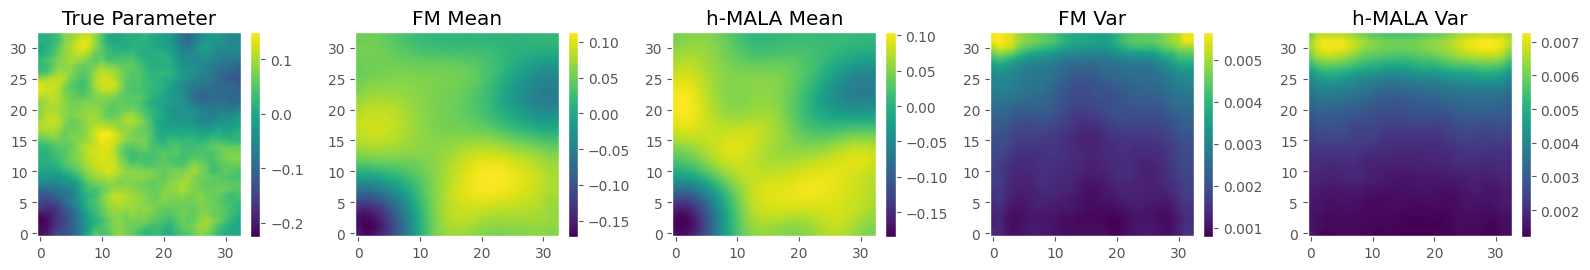

: 

In [ ]:
layer_idx = 0
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

im0 = ax[0].imshow(utrue, origin="lower", interpolation="bilinear")
ax[0].set_title("True Parameter")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(u_means, origin="lower", interpolation="bilinear")
ax[1].set_title("FM Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(
    hmala_mean, origin="lower", interpolation="bilinear"
)
ax[2].set_title("h-MALA Mean")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(u_var, origin="lower", interpolation="bilinear")
ax[3].set_title("FM Var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

im4 = ax[4].imshow(hmala_var, origin="lower", interpolation="bilinear")
ax[4].set_title("h-MALA Var")
ax[4].grid(False)
fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

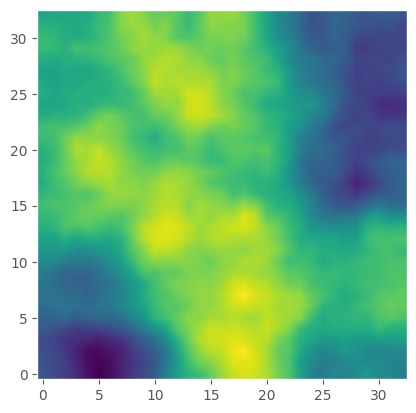

In [124]:
plt.imshow(u_samples[np.random.choice(1000)], origin="lower", interpolation="bilinear")
plt.grid(False)